# Prediction using SVM and Captions

In [4]:
import pandas as pd
import numpy as np
from string import punctuation
import pyprind
from collections import Counter
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras import preprocessing

# load labels and captions
def read_caps(fname):
    """Load the captions into a dataframe"""
    vn = []
    cap = []
    df = pd.DataFrame();
    with open(fname) as f:
        for line in f:
            pairs = line.split()
            vn.append(pairs[0])
            cap.append(pairs[1])
        df['video']=vn
        df['caption']=cap
    return df

def Get_score(Y_pred,Y_true):
    '''Calculate the Spearmann"s correlation coefficient'''
    Y_pred = np.squeeze(Y_pred)
    Y_true = np.squeeze(Y_true)
    if Y_pred.shape != Y_true.shape:
        print('Input shapes don\'t match!')
    else:
        if len(Y_pred.shape) == 1:
            Res = pd.DataFrame({'Y_true':Y_true,'Y_pred':Y_pred})
            score_mat = Res[['Y_true','Y_pred']].corr(method='spearman',min_periods=1)
            print('The Spearman\'s correlation coefficient is: %.3f' % score_mat.iloc[1][0])
        else:
            for ii in range(Y_pred.shape[1]):
                Get_score(Y_pred[:,ii],Y_true[:,ii])

/home/stone/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load data

In [5]:
# load the captions
#cap_path = '/media/win/Users/ecelab-adm/Desktop/DataSet_me18me/me18me-devset/dev-set/dev-set_video-captions.txt'
cap_path = '/media/stone/Data/DataSet_me18me/me18me-devset/dev-set/dev-set_video-captions.txt'
df_cap_train=read_caps(cap_path)
print('train data set shape',df_cap_train.shape)

# load test captions
#cap_path = '/media/win/Users/ecelab-adm/Desktop/DataSet_me18me/test-set/test-set_videos-captions.txt'
cap_path = '/media/stone/Data/DataSet_me18me/testset/test-set_videos-captions.txt'
df_cap_test=read_caps(cap_path)
print('test data set shape',df_cap_test.shape)

df_cap = pd.concat([df_cap_train,df_cap_test],ignore_index=True)
print('shape after concatenation',df_cap.shape)

# load the ground truth values
#label_path = '/media/win/Users/ecelab-adm/Desktop/DataSet_me18me/me18me-devset/dev-set/ground-truth/' 
label_path = '/media/stone/Data/DataSet_me18me/me18me-devset/dev-set/ground-truth/'

labels=pd.read_csv(label_path+'ground-truth_dev-set.csv')

counts = Counter()
# setup prograss tracker
pbar = pyprind.ProgBar(len(df_cap['caption']), title='Counting word occurrences')
for i, cap in enumerate(df_cap['caption']):
    # replace punctuations with space
    # convert words to lower case 
    text = ''.join([c if c not in punctuation else ' ' for c in cap]).lower()
    df_cap.loc[i,'caption'] = text
    pbar.update()
    counts.update(text.split())
    
df_cap.head()

Counting word occurrences


train data set shape (8000, 2)
test data set shape (2000, 2)
shape after concatenation (10000, 2)


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


,video,caption
0,video10.webm,couple relaxing on picnic crane shot
1,video100.webm,cute black and white cats in cage at animal sh...
2,video10000.webm,owl in tree close up
3,video10001.webm,around the house on a laptop
4,video10002.webm,beautiful young girl with apple


## Vectorize the captions

In [6]:
# build the word index
len_token = len(counts)
tokenizer = Tokenizer(num_words=len_token)
tokenizer.fit_on_texts(list(df_cap.caption.values))
sequences = tokenizer.texts_to_sequences(list(df_cap_train.caption.values))
sequences[:2]

maxlen = 10
X_seq = preprocessing.sequence.pad_sequences(sequences,maxlen=maxlen)
test_sequences = tokenizer.texts_to_sequences(list(df_cap_test.caption.values))
X_test = preprocessing.sequence.pad_sequences(test_sequences,maxlen=maxlen)
X_test.shape

(2000, 10)

In [9]:
Y = labels[['short-term_memorability','long-term_memorability']].values
X = X_seq
X_all = np.concatenate([X,X_test])
X_all.shape

(10000, 10)

## Build model and CV

In [15]:
# building a pipeline
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.decomposition import KernelPCA, PCA
from sklearn.preprocessing import StandardScaler

def svr_pipline():
    #stdi = StandardScaler()
    pca = PCA(n_components=0.98,svd_solver='full')
    svr = svm.SVR(C=1.0,epsilon=0.01,kernel='rbf')
    svr_pip = Pipeline([('pca',pca),('svr',svr)])
    return svr_pip

def spearman_corr(x_pred,x_true):
    "The official performance matrix: Spearman's rank correlation"
    a = pd.DataFrame()
    a['true'] = x_true
    a['pred'] = x_pred
    res = a[['true','pred']].corr(method='spearman',min_periods=1)
    return res.iloc[0,1]

from sklearn.metrics import make_scorer
spearman = make_scorer(spearman_corr,greater_is_better=True)



In [17]:
from sklearn.model_selection import GridSearchCV
params = {'pca__n_components':[0.7,0.8,0.9,0.95],
         'svr__C':[0.01,0.1,1,2,5],
         'svr__epsilon':[0.01,0.1,0.2],
         'svr__kernel':['rbf']}

MP_svr_s = svr_pipline()
MP_svr_l = svr_pipline()
A = GridSearchCV(MP_svr_s,params,scoring=spearman,cv=3,n_jobs=-1)
A.fit(X,Y[:,0])

B = GridSearchCV(MP_svr_l,params,scoring=spearman,cv=3,n_jobs=-1)
B.fit(X,Y[:,1])
# save results
# To serialize
import pickle
with open('svr_captions_short.pkl', 'wb') as fid:
    pickle.dump(A, fid)
with open('svr_captions_long.pkl','wb') as fid:
    pickle.dump(B,fid)
# To deserialize estimator later
#with open('our_estimator.pkl', 'rb') as fid:
#    gnb = pickle.load(fid)

# Predict the test data and get ready to submit

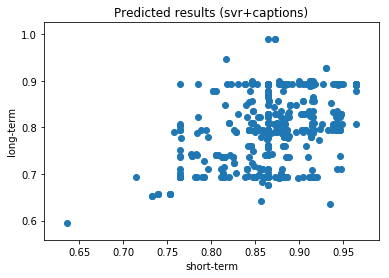

In [23]:
# import saved models
import pickle
with open('svr_captions_short.pkl', 'rb') as fid:
    A=pickle.load(fid)
y_short_pred=A.best_estimator_.predict(X_test)

with open('svr_captions_long.pkl', 'rb') as fid:
    B=pickle.load(fid)
    
y_long_pred = B.best_estimator_.predict(X_test)

# visualize the prediction results
plt.figure()
plt.scatter(y_short_pred,y_long_pred,marker='o')
plt.xlabel('short-term')
plt.ylabel('long-term')
plt.title('Predicted results (svr+captions)')
#plt.show()
plt.savefig('svr+captions.eps')

In [20]:
# print the best score
print('Best short-term spearman score is {:.3f}'.format(A.best_score_))
A.best_params_
print('Best long-term spearman score is {:.3f}'.format(B.best_score_))
B.best_params_

Best short-term spearman score is 0.175
Best long-term spearman score is 0.068


{'pca__n_components': 0.9,
 'svr__C': 0.1,
 'svr__epsilon': 0.01,
 'svr__kernel': 'rbf'}

# Save prediction results

In [21]:
df_cap_test['short-term'] = y_short_pred
df_cap_test['long-term'] = y_long_pred
df_cap_test['confidence_interval'] = 0 # not meaningful, this is required but not used for performance evaluation

df_cap_test.head()

,video,caption,short-term,long-term,confidence_interval
0,video1.webm,snow-and-string-lights,0.864115,0.793809,0
1,video1000.webm,clown-fish-swimming-by-rocks-and-coral,0.864115,0.793809,0
2,video1002.webm,cook-preparing-traditional-asian-street-food-m...,0.864115,0.793809,0
3,video1008.webm,beautiful-girl-running-on-sunlit-wheat-field-s...,0.944365,0.793809,0
4,video1010.webm,piece-of-space-shuttle-breaking-off-and-earth-...,0.864115,0.793809,0


In [22]:
res = df_cap_test[['video','short-term','confidence_interval']]
run_name = 'me18in_TheHuskies_shortterm_run5-svr_caps.csv'
res.to_csv(path_or_buf=run_name,sep=',',header=False,index=False)

res1 = df_cap_test[['video','long-term','confidence_interval']]
run_name1 = 'me18in_TheHuskies_longterm_run5-svr_caps.csv'
res1.to_csv(path_or_buf=run_name1,sep=',',header=False,index=False)